# Core (Always run)

In [1]:
import shap
import mygene
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, learning_curve, cross_validate, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_recall_curve, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, label_binarize
from itertools import cycle
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold, RFE, SelectFromModel
from sklearn.pipeline import Pipeline

Global Variables

In [2]:
path_to_data = "data/"
dataset_file_name = "dataset.pq"

# Preprocess

## Load datasets

In [3]:
df = pd.read_parquet(path_to_data + dataset_file_name)

## Cleaning

Transpose

In [4]:
df = df.transpose()

print(f'Dataframe shape after transpose: {df.shape}')

df.head()

Dataframe shape after transpose: (1215, 60660)


gene_id,ENSG00000000003.15,ENSG00000000005.6,ENSG00000000419.13,ENSG00000000457.14,ENSG00000000460.17,ENSG00000000938.13,ENSG00000000971.16,ENSG00000001036.14,ENSG00000001084.13,ENSG00000001167.14,...,ENSG00000288661.1,ENSG00000288662.1,ENSG00000288663.1,ENSG00000288665.1,ENSG00000288667.1,ENSG00000288669.1,ENSG00000288670.1,ENSG00000288671.1,ENSG00000288674.1,ENSG00000288675.1
TCGA-XX-A899-01,34.003101,1.0062,97.700798,15.762600,4.938200,28.325100,41.606098,45.998100,17.285400,25.175501,...,0.0,1.2377,0.7427,0.0,0.0000,0.0,15.863000,0.0,0.1467,1.5913
TCGA-EW-A2FS-01,16.524300,0.9470,52.427799,7.086000,2.360400,6.680100,16.640900,56.548500,11.143500,40.911900,...,0.0,0.0000,0.5171,0.0,0.6193,0.0,4.348700,0.0,0.0196,1.0569
TCGA-AO-A0JI-01,54.170799,0.3428,136.497299,12.876600,10.123200,3.719300,10.789400,69.652901,17.129200,112.259499,...,0.0,0.0000,0.1395,0.0,0.0000,0.0,11.721900,0.0,0.0526,1.4200
TCGA-BH-A18V-01,16.247601,1.0984,199.185898,13.985400,22.257099,16.917999,29.128599,39.353401,21.069799,83.823997,...,0.0,0.0000,0.2489,0.0,0.0000,0.0,27.962799,0.0,0.0070,2.1311
TCGA-OL-A5RX-01,76.812401,2.6117,111.240097,33.484798,6.388500,9.312700,21.594500,53.042702,12.505700,54.859402,...,0.0,0.0000,0.6476,0.0,0.0000,0.0,11.892200,0.0,0.0938,1.1229


Apply subtypes

In [55]:
excell_sheet_df = pd.read_excel('./assets/subtype_sheet.xlsx', sheet_name='RNA-Seq 1148')

for sample_id in df.index:

    if sample_id in excell_sheet_df['Sample ID'].values:
        subtype = excell_sheet_df.loc[excell_sheet_df['Sample ID'] == sample_id, 'PAM50'].values[0]
        df.at[sample_id, 'Subtype'] = subtype

df.head()

gene_id,ENSG00000000003.15,ENSG00000000005.6,ENSG00000000419.13,ENSG00000000457.14,ENSG00000000460.17,ENSG00000000938.13,ENSG00000000971.16,ENSG00000001036.14,ENSG00000001084.13,ENSG00000001167.14,...,ENSG00000288662.1,ENSG00000288663.1,ENSG00000288665.1,ENSG00000288667.1,ENSG00000288669.1,ENSG00000288670.1,ENSG00000288671.1,ENSG00000288674.1,ENSG00000288675.1,Subtype
TCGA-XX-A899-01,34.0031,1.0062,97.7008,15.7626,4.9382,28.3251,41.6061,45.9981,17.2854,25.1755,...,1.2377,0.7427,0.0,0.0000,0.0,15.8630,0.0,0.1467,1.5913,LumA
TCGA-EW-A2FS-01,16.5243,0.9470,52.4278,7.0860,2.3604,6.6801,16.6409,56.5485,11.1435,40.9119,...,0.0000,0.5171,0.0,0.6193,0.0,4.3487,0.0,0.0196,1.0569,LumA
TCGA-AO-A0JI-01,54.1708,0.3428,136.4973,12.8766,10.1232,3.7193,10.7894,69.6529,17.1292,112.2595,...,0.0000,0.1395,0.0,0.0000,0.0,11.7219,0.0,0.0526,1.4200,LumA
TCGA-BH-A18V-01,16.2476,1.0984,199.1859,13.9854,22.2571,16.9180,29.1286,39.3534,21.0698,83.8240,...,0.0000,0.2489,0.0,0.0000,0.0,27.9628,0.0,0.0070,2.1311,Basal
TCGA-OL-A5RX-01,76.8124,2.6117,111.2401,33.4848,6.3885,9.3127,21.5945,53.0427,12.5057,54.8594,...,0.0000,0.6476,0.0,0.0000,0.0,11.8922,0.0,0.0938,1.1229,LumA


Look for NaN

In [6]:
if df.isna().sum().sum() > 0:
    print("Dataframe contains missing values. Dropping missing values.")
    print(f'Number of missing values: {df.isna().sum().sum()}')

    df = df.dropna()

    print("Missing values dropped.")
    print(f'Number of remaining missing values: {df.isna().sum().sum()}')
else:
    print("Dataframe does not contain missing values.")

Dataframe contains missing values. Dropping missing values.
Number of missing values: 70
Missing values dropped.
Number of remaining missing values: 0


# Exploratory Data Analysis (EDA)

Plot 1: Subtype distribution plot

More info about the subtypes in this paper: https://pmc.ncbi.nlm.nih.gov/articles/PMC6985186/

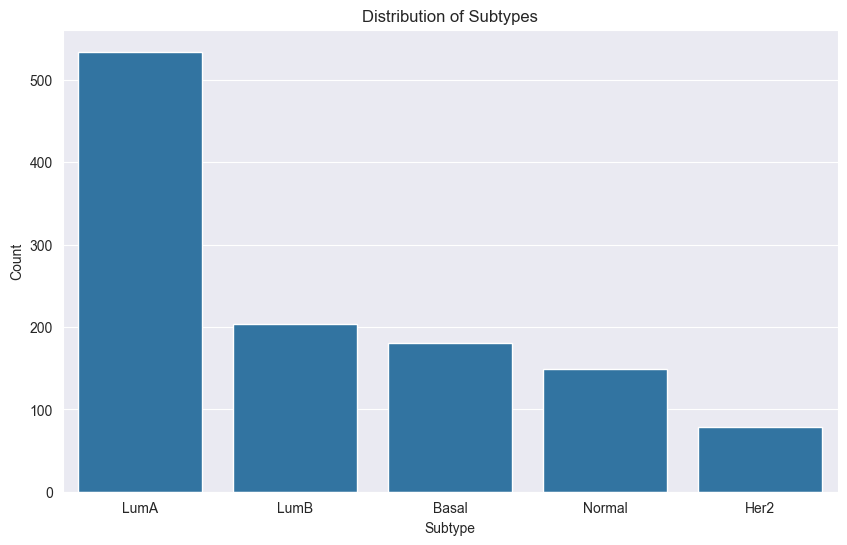

In [7]:
plot_df = df.copy()

plt.figure(figsize=(10, 6))
sns.countplot(data=plot_df, x='Subtype', order=plot_df['Subtype'].value_counts().index)
plt.title('Distribution of Subtypes')
plt.xlabel('Subtype')
plt.ylabel('Count')
plt.show()

Plot 2: Scatter plot

Observation: Contains a few outliers, not entirely sure what to do about them.

https://stats.stackexchange.com/questions/533503/when-should-you-remove-outliers-entire-dataset-or-train-dataset

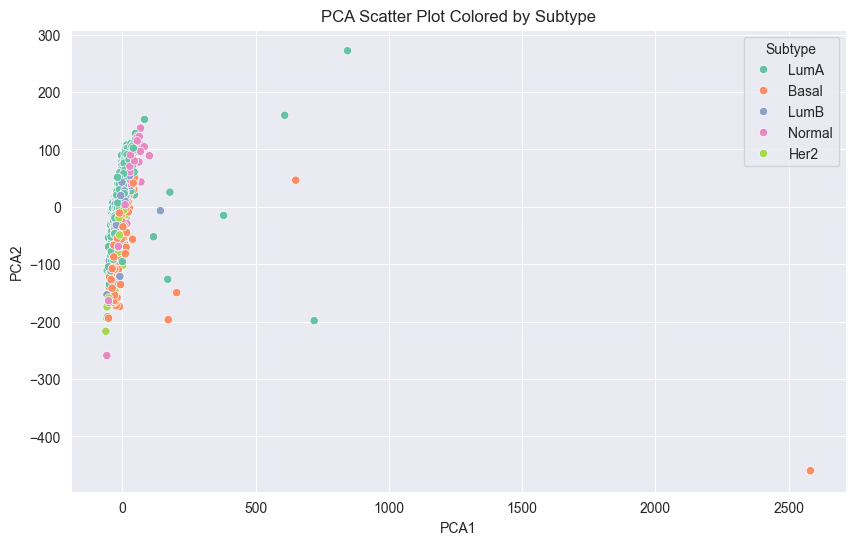

In [8]:
x_log_transformed = np.log1p(plot_df.select_dtypes(include=np.number))

scaler = StandardScaler()
df_scaled = scaler.fit_transform(x_log_transformed)

PCA_model = PCA(n_components=2)
pca_result = PCA_model.fit_transform(df_scaled)
plot_df['PCA1'] = pca_result[:, 0]
plot_df['PCA2'] = pca_result[:, 1]
plt.figure(figsize=(10, 6))
sns.scatterplot(data=plot_df, x='PCA1', y='PCA2', hue='Subtype', palette='Set2')
plt.title('PCA Scatter Plot Colored by Subtype')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Subtype')
plt.show()

Plot 2.1: Scatter plot with outliers removed

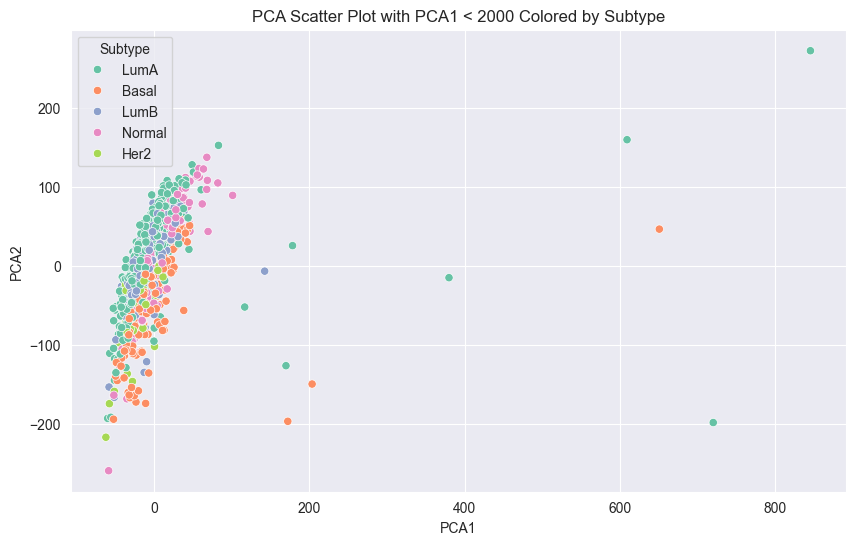

In [9]:
# Filter out outliers based on PCA1 and PCA2
filtered_plot_df = plot_df[plot_df['PCA1'] < 2000]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=filtered_plot_df, x='PCA1', y='PCA2', hue='Subtype', palette='Set2')
plt.title('PCA Scatter Plot with PCA1 < 2000 Colored by Subtype')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Subtype')
plt.show()  

# Training

## Setup

Stratified K fold

In [10]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
n_jobs = -1

lr_base_model = LogisticRegression(max_iter=7500, random_state=42)
rf_base_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=n_jobs)
xgb_base_model = XGBClassifier(objective='multi:softmax', random_state=42, n_jobs=n_jobs, eval_metric='mlogloss')

Model training function

In [11]:
def setup_pipeline(model, type: str) -> Pipeline:
    """Returns pipeline based on model and type of feature selection. Feature selection types: rfe, sbm, skb"""

    base_list = [
        ('scaler', StandardScaler()),
        ('variance_threshold', VarianceThreshold(threshold=0.0))
    ]

    if type == 'rfe':
        return Pipeline(base_list + [
            ('feature_selection', RFE(estimator=LogisticRegression(max_iter=1500, random_state=42), n_features_to_select=50, step=0.1)),
            ('model', model)
        ])
    elif type == 'sfm':
        return Pipeline(base_list + [
            ('feature_selection', SelectFromModel(estimator=RandomForestClassifier(n_estimators=100, random_state=42), max_features=50)),
            ('model', model)
        ])
    elif type == 'skb':
        return Pipeline(base_list + [
            ('feature_selection', SelectKBest(score_func=f_classif, k=50)),
            ('model', model)
        ])
    else:
        raise ValueError("Invalid feature selection type. Choose from 'lr', 'rf', or 'skb'.")
    
def print_score(scores):
    print(f"Scores for each fold: {scores}")
    print(f"Average score: {np.mean(scores)}")
    print(f"Standard deviation: {np.std(scores)}")

Labeling

In [12]:
encoder = LabelEncoder()

y = encoder.fit_transform(df['Subtype'])
X = df.drop(columns=['Subtype'])

Normalization - log2

In [13]:
X = np.log2(X + 1)

Train test split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Training Logistic Regression using LR, RF and KBest for feature selection

Logistic Regression - RFE(LogisticRegression) Feature Selection

In [15]:
logreg_pipeline_rfe = setup_pipeline(model=lr_base_model, type='rfe')

logreg_rfe_result = cross_validate(
    estimator=logreg_pipeline_rfe, 
    X=X_train, 
    y=y_train, 
    cv=skf, 
    scoring='f1_macro',
    n_jobs=n_jobs,
    return_train_score=True
)

print_score(logreg_rfe_result['test_score'])

Scores for each fold: [0.8230894  0.71842531 0.8486952  0.83060581 0.82013362]
Average score: 0.8081898680652497
Standard deviation: 0.04596842554326064


Logistic Regression - SelectBestModel(RandomForest) Feature Selection

In [16]:
logreg_pipeline_sfm = setup_pipeline(model=lr_base_model, type='sfm')

logreg_sfm_result = cross_validate(
    estimator=logreg_pipeline_sfm,
    X=X_train,
    y=y_train,
    cv=skf,
    scoring='f1_macro',
    n_jobs=n_jobs,
    return_train_score=True
)

print_score(logreg_sfm_result['test_score'])

Scores for each fold: [0.83066194 0.89247455 0.94360774 0.89044036 0.91363682]
Average score: 0.8941642823317192
Standard deviation: 0.03707588230867071


Logistic Regression - SelectKBest Feature Selection

In [17]:
logreg_pipeline_kbest = setup_pipeline(model=lr_base_model, type='skb')

logreg_kbest_result = cross_validate(
    estimator=logreg_pipeline_kbest,
    X=X_train,
    y=y_train,
    cv=skf,
    scoring='f1_macro',
    n_jobs=n_jobs,
    return_train_score=True
)

print_score(logreg_kbest_result['test_score'])

Scores for each fold: [0.86884732 0.8331879  0.87601276 0.90956414 0.89518366]
Average score: 0.8765591553547905
Standard deviation: 0.025988604781557876


## Training Random Forest using LR, RF and KBest for feature selection

Random Forest - RFE(LogisticRegression) Feature Selection

In [18]:
rf_pipeline_rfe = setup_pipeline(model=rf_base_model, type='rfe')

rf_rfe_result = cross_validate(
    estimator=rf_pipeline_rfe,
    X=X_train,
    y=y_train,
    cv=skf,
    scoring='f1_macro',
    n_jobs=n_jobs,
    return_train_score=True
)

print_score(rf_rfe_result['test_score'])

Scores for each fold: [0.82478705 0.81019404 0.86267094 0.85183069 0.8566214 ]
Average score: 0.8412208225648575
Standard deviation: 0.02021180008414615


Random Forest - SelectBestModel(RandomForest) Feature Selection

In [19]:
rf_pipeline_sfm = setup_pipeline(model=rf_base_model, type='sfm')

rf_sfm_result = cross_validate(
    estimator=rf_pipeline_sfm,
    X=X_train,
    y=y_train,
    cv=skf,
    scoring='f1_macro',
    n_jobs=n_jobs,
    return_train_score=True
)

print_score(rf_sfm_result['test_score'])

Scores for each fold: [0.87947003 0.84965194 0.87437737 0.85353084 0.90138557]
Average score: 0.8716831508714709
Standard deviation: 0.018788342137790303


Random Forest - SelectKBest Feature Selection

In [20]:
rf_pipeline_kbest = setup_pipeline(model=rf_base_model, type='skb')

rf_kbest_result = cross_validate(
    estimator=rf_pipeline_kbest,
    X=X_train,
    y=y_train,
    cv=skf,
    scoring='f1_macro',
    n_jobs=n_jobs,
    return_train_score=True
)

print_score(rf_kbest_result['test_score'])

Scores for each fold: [0.90051282 0.86619541 0.88412836 0.8872913  0.89234845]
Average score: 0.8860952687761798
Standard deviation: 0.011386584119903658


## Training XGBoost using LR, RF and KBest for feature selection

XGBoost - RFE(LogisticRegression) Feature Selection

In [21]:
xgb_pipeline_rfe = setup_pipeline(model=xgb_base_model, type='rfe')

xgb_rfe_result = cross_validate(
    xgb_pipeline_rfe,
    X_train,
    y_train,
    cv=skf,
    scoring='f1_macro',
    n_jobs=n_jobs,
    return_train_score=True
)

print_score(xgb_rfe_result['test_score'])

Scores for each fold: [0.83176645 0.79035734 0.86690663 0.82861423 0.85280382]
Average score: 0.834089694411345
Standard deviation: 0.02598101864702529


XGBoost - SelectBestModel(RandomForest) Feature Selection

In [22]:
xgb_pipeline_sfm = setup_pipeline(model=xgb_base_model, type='sfm')

xgb_sfm_result = cross_validate(
    estimator=xgb_pipeline_sfm,
    X=X_train,
    y=y_train,
    cv=skf,
    scoring='f1_macro',
    n_jobs=n_jobs,
    return_train_score=True
)

print_score(xgb_sfm_result['test_score'])

Scores for each fold: [0.86063335 0.85466768 0.90120354 0.87720047 0.91342301]
Average score: 0.8814256083441192
Standard deviation: 0.02272072764545896


XGBoost - SelectKBest Feature Selection

In [23]:
xgb_pipeline_kbest = setup_pipeline(model=xgb_base_model, type='skb')

xgb_kbest_result = cross_validate(
    estimator=xgb_pipeline_kbest,
    X=X_train,
    y=y_train,
    cv=skf,
    scoring='f1_macro',
    n_jobs=n_jobs,
    return_train_score=True
)

print_score(xgb_kbest_result['test_score'])

Scores for each fold: [0.87647405 0.85578997 0.88643787 0.89092763 0.896775  ]
Average score: 0.8812809037773566
Standard deviation: 0.014370904238098694


## Final training score

In [24]:
all_scores = {
    'logistic_regression_rfe': {
        'result': logreg_rfe_result,
        'base_model': lr_base_model,
        'type': 'rfe'
    },
    'logistic_regression_sfm': {
        'result': logreg_sfm_result,
        'base_model': lr_base_model,
        'type': 'sfm'
    },
    'logistic_regression_skb': {
        'result': logreg_kbest_result,
        'base_model': lr_base_model,
        'type': 'skb'
    },
    'random_forest_rfe': {
        'result': rf_rfe_result,
        'base_model': rf_base_model,
        'type': 'rfe'
    },
    'random_forest_sfm': {
        'result': rf_sfm_result,
        'base_model': rf_base_model,
        'type': 'sfm'
    },
    'random_forest_skb': {
        'result': rf_kbest_result,
        'base_model': rf_base_model,
        'type': 'skb'
    },
    'xgboost_rfe': {
        'result': xgb_rfe_result,
        'base_model': xgb_base_model,
        'type': 'rfe'
    },
    'xgboost_sfm': {
        'result': xgb_sfm_result,
        'base_model': xgb_base_model,
        'type': 'sfm'
    },
    'xgboost_skb': {
        'result': xgb_kbest_result,
        'base_model': xgb_base_model,
        'type': 'skb'
    }
}

results = []
for model_name, data in all_scores.items():
    val_scores = data['result']['test_score']
    train_scores = data['result']['train_score']

    mean_val_score = np.mean(val_scores)
    std_val_score = np.std(val_scores)
    mean_train_score = np.mean(train_scores)
    overfitting_gap = mean_train_score - mean_val_score

    results.append({
        'model': model_name,
        'mean_val_f1': mean_val_score,
        'std_dev': std_val_score,
        'mean_train_f1': mean_train_score,
        'overfitting_gap': overfitting_gap
    })

report_df = pd.DataFrame(results)

report_df = report_df.sort_values(by='overfitting_gap', ascending=True)

pd.set_option('display.precision', 4)
pd.set_option('display.max_colwidth', None)

print(report_df.to_string(index=False))

                  model  mean_val_f1  std_dev  mean_train_f1  overfitting_gap
logistic_regression_sfm       0.8942   0.0371         0.9603           0.0661
logistic_regression_skb       0.8766   0.0260         0.9664           0.0898
      random_forest_skb       0.8861   0.0114         1.0000           0.1139
            xgboost_sfm       0.8814   0.0227         1.0000           0.1186
            xgboost_skb       0.8813   0.0144         1.0000           0.1187
      random_forest_sfm       0.8717   0.0188         1.0000           0.1283
logistic_regression_rfe       0.8082   0.0460         0.9565           0.1484
      random_forest_rfe       0.8412   0.0202         1.0000           0.1588
            xgboost_rfe       0.8341   0.0260         1.0000           0.1659


# Training Results Analysis

Learning Curve plot

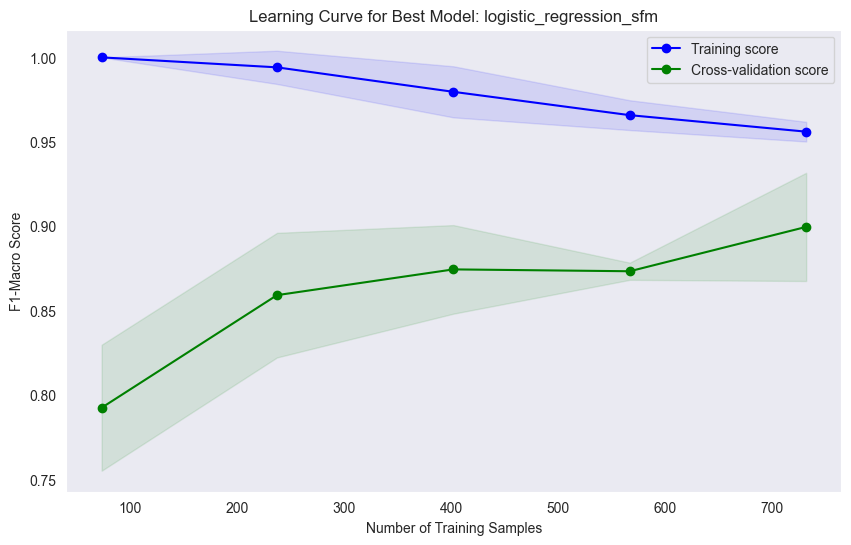

In [25]:
best_model_name = report_df.iloc[0]['model']

best_pipeline = setup_pipeline(
    model=all_scores[best_model_name]['base_model'],
    type=all_scores[best_model_name]['type']
)

train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_pipeline,
    X=X_train,
    y=y_train,
    cv=skf,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.xlabel('Number of Training Samples')
plt.ylabel('F1-Macro Score')

plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='green', label='Cross-validation score')

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='green')

plt.legend(loc='best')
plt.title(f'Learning Curve for Best Model: {best_model_name}')
plt.grid()
plt.show()

Confusion matrix

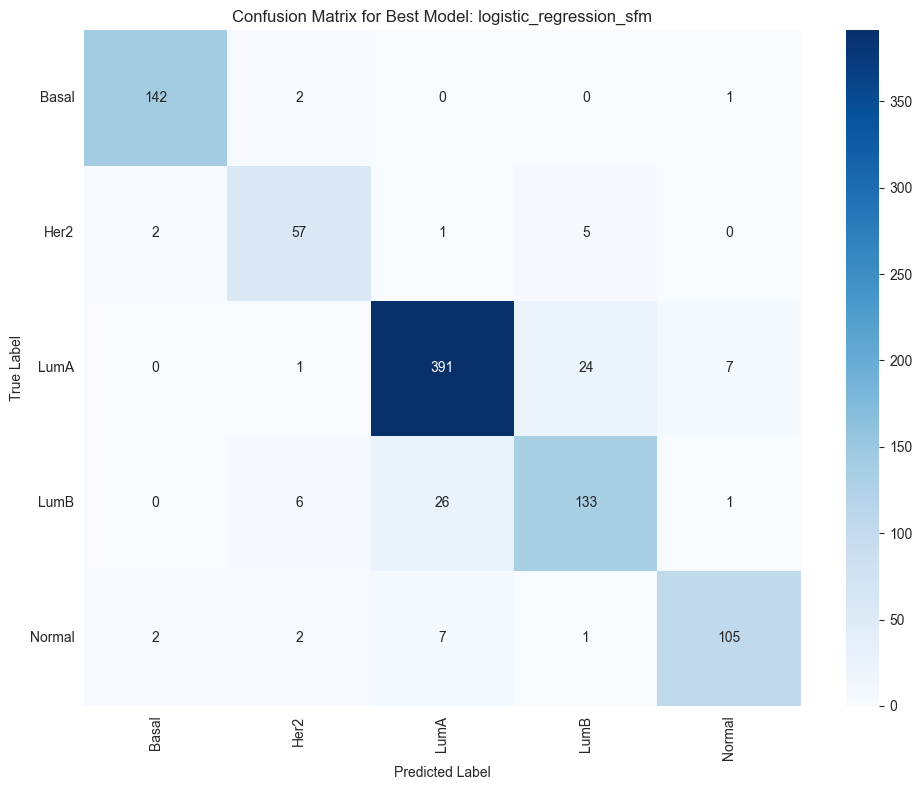

In [26]:
cv_predict_scores = cross_val_predict(
    best_pipeline,
    X_train,
    y_train,
    cv=skf,
    n_jobs=n_jobs
)

cm = confusion_matrix(y_train, cv_predict_scores)
plt.figure(figsize=(10, 8))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title(f'Confusion Matrix for Best Model: {best_model_name}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

ROC Curve

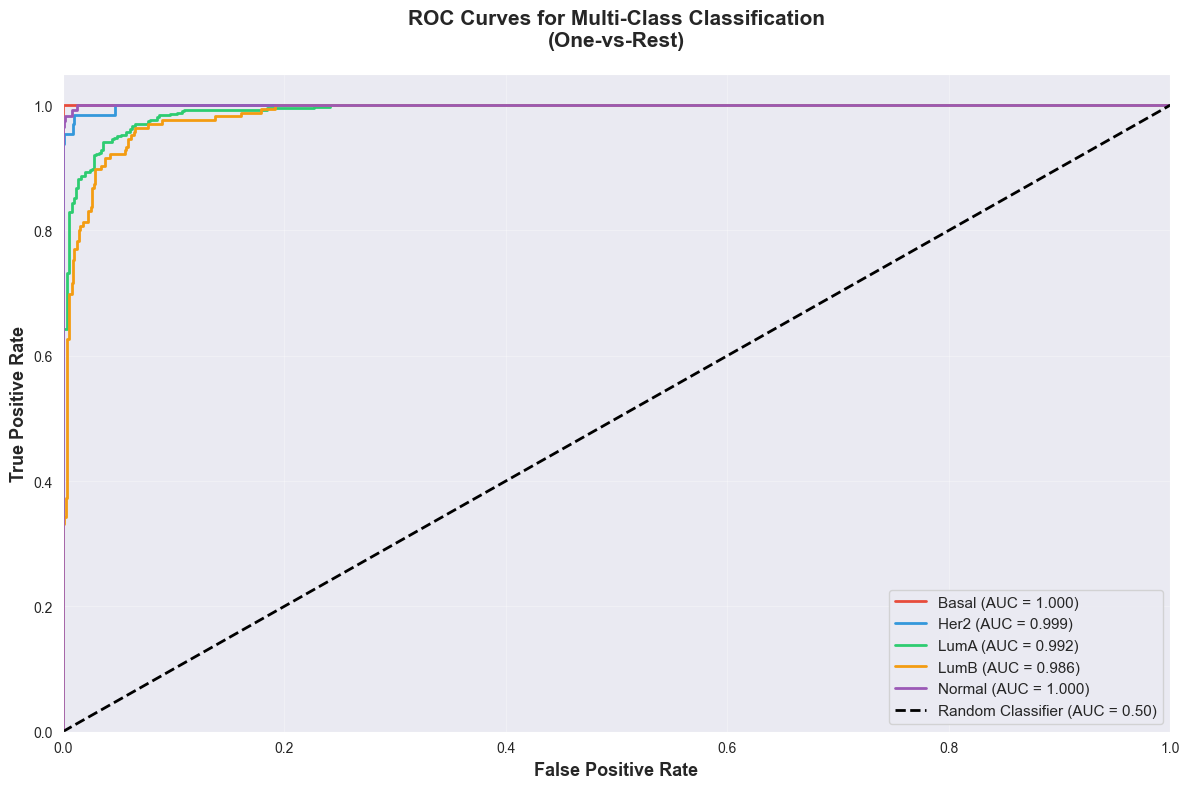

In [27]:
roc_curve_model = best_pipeline.fit(X_train, y_train)

y_train_proba = roc_curve_model.predict_proba(X_train)

y_train_binarized = label_binarize(y_train, classes=np.arange(len(encoder.classes_)))

plt.figure(figsize=(12, 8))
colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6']

auc_scores = []

for i, (class_name, color) in enumerate(zip(encoder.classes_, colors)):
    fpr, tpr, _ = roc_curve(y_train_binarized[:, i], y_train_proba[:, i])
    roc_auc = auc(fpr, tpr)
    auc_scores.append(roc_auc)
    
    plt.plot(fpr, tpr, color=color, lw=2, 
             label=f'{class_name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

plt.xlabel('False Positive Rate', fontsize=13, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=13, fontweight='bold')
plt.title('ROC Curves for Multi-Class Classification\n(One-vs-Rest)', fontsize=15, fontweight='bold', pad=20)
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tight_layout()
plt.show()

# Hyper Parameter Tuning

In [28]:
n_features = [50, 75, 100]

param_grid = [
    {
        'model__penalty': ['l1'],
        'model__solver': ['saga'],
        'model__C': [0.01, 0.1, 1, 10, 50],
        'model__class_weight': ['balanced', None]
    },
    {
        'model__penalty': ['l2'],
        'model__solver': ['lbfgs', 'newton-cg', 'newton-cholesky'],
        'model__C': [0.01, 0.1, 1, 10, 50],
        'model__class_weight': ['balanced', None]
    }
]

# Insert N feature based on feature selection method
for grid in param_grid:
    if all_scores[best_model_name]['type'] == 'rfe':
        grid['feature_selection__n_features_to_select'] = n_features
    elif all_scores[best_model_name]['type'] == 'sfm':
        grid['feature_selection__max_features'] = n_features
    elif all_scores[best_model_name]['type'] == 'skb':
        grid['feature_selection__k'] = n_features
    else:
        raise ValueError("Invalid feature selection type. Choose from 'rfe', 'sfm', or 'skb'.")

grid_search = GridSearchCV(
    estimator=best_pipeline,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=skf,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print(f"Best F1-Macro Score: {grid_search.best_score_:.4f}")
print("Best Parameters Found:")
print(grid_search.best_params_)

best_model = grid_search.best_estimator_

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best F1-Macro Score: 0.9010
Best Parameters Found:
{'feature_selection__max_features': 50, 'model__C': 10, 'model__class_weight': None, 'model__penalty': 'l1', 'model__solver': 'saga'}


# Hyper Parameter Tuning Results Analysis

Learning curve plot

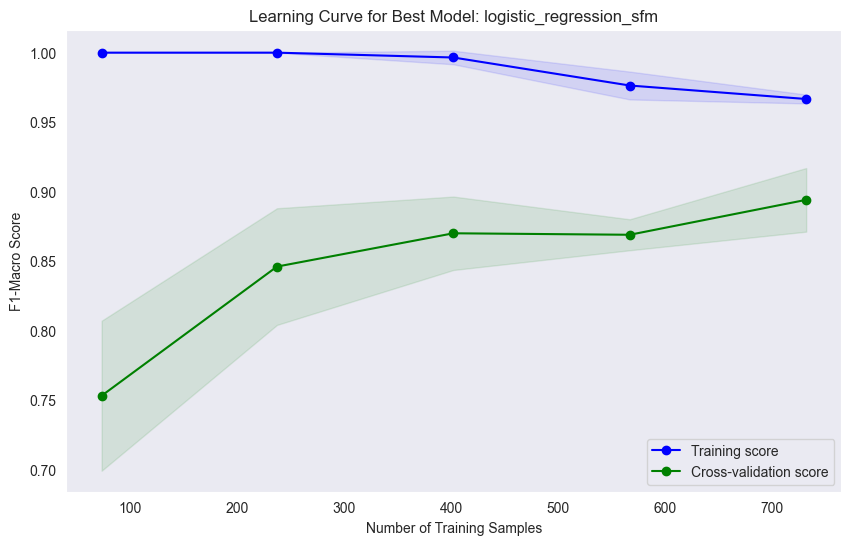

In [29]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_model,
    X=X_train,
    y=y_train,
    cv=skf,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.xlabel('Number of Training Samples')
plt.ylabel('F1-Macro Score')

plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='green', label='Cross-validation score')

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='green')

plt.legend(loc='best')
plt.title(f'Learning Curve for Best Model: {best_model_name}')
plt.grid()
plt.show()

Confusion matrix

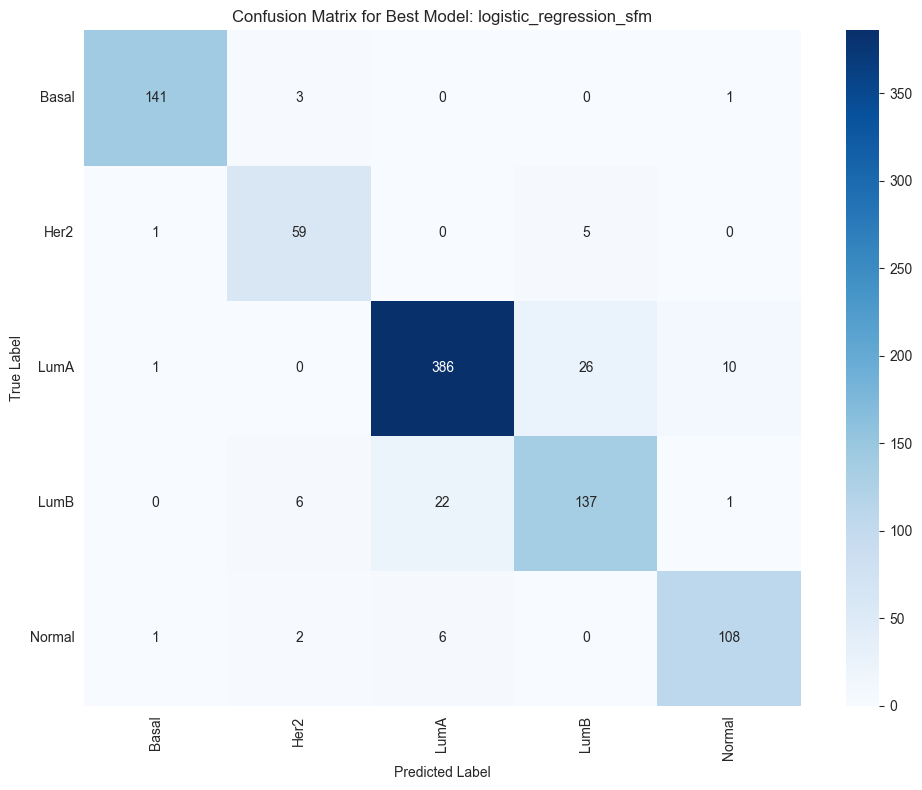

In [30]:
cv_predict_scores = cross_val_predict(
    best_model,
    X_train,
    y_train,
    cv=skf,
    n_jobs=n_jobs
)

cm = confusion_matrix(y_train, cv_predict_scores)
plt.figure(figsize=(10, 8))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title(f'Confusion Matrix for Best Model: {best_model_name}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

ROC Curve

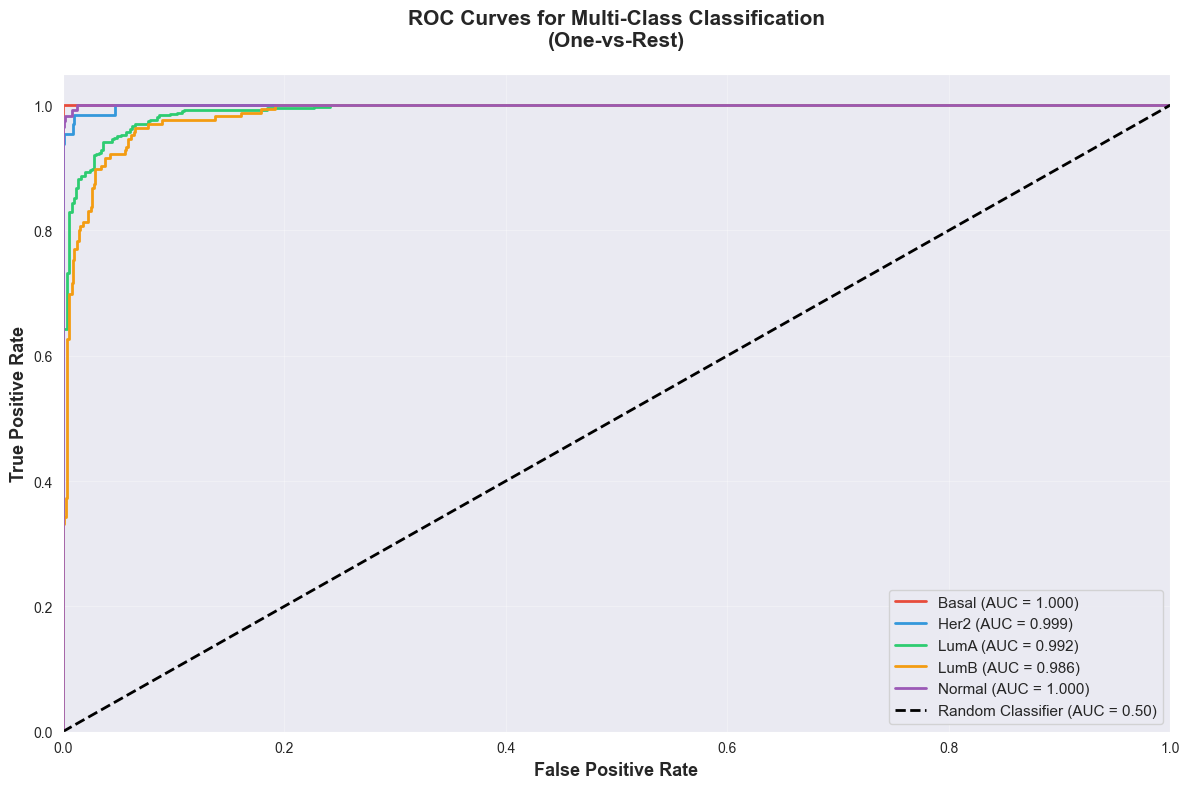

In [31]:
roc_curve_model = best_pipeline.fit(X_train, y_train)

y_train_proba = roc_curve_model.predict_proba(X_train)

y_train_binarized = label_binarize(y_train, classes=np.arange(len(encoder.classes_)))

plt.figure(figsize=(12, 8))
colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6']

auc_scores = []

for i, (class_name, color) in enumerate(zip(encoder.classes_, colors)):
    fpr, tpr, _ = roc_curve(y_train_binarized[:, i], y_train_proba[:, i])
    roc_auc = auc(fpr, tpr)
    auc_scores.append(roc_auc)
    
    plt.plot(fpr, tpr, color=color, lw=2, 
             label=f'{class_name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

plt.xlabel('False Positive Rate', fontsize=13, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=13, fontweight='bold')
plt.title('ROC Curves for Multi-Class Classification\n(One-vs-Rest)', fontsize=15, fontweight='bold', pad=20)
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tight_layout()
plt.show()

# Shap Analysis

In [32]:
scaler_step = best_model.named_steps['scaler']
vt_step = best_model.named_steps['variance_threshold']
selector_step = best_model.named_steps['feature_selection']
model_step = best_model.named_steps['model']

gene_ids_array = np.array(X_train.columns)

vt_mask = vt_step.get_support()
genes_after_vt = gene_ids_array[vt_mask]

skb_mask = selector_step.get_support()
final_selected_gene_ids = genes_after_vt[skb_mask]

final_selected_gene_ids_transformed = [gene_id.split('.')[0] for gene_id in final_selected_gene_ids]

mg = mygene.MyGeneInfo()
query_results = mg.querymany(
    final_selected_gene_ids_transformed,
    scopes='ensembl.gene', 
    fields='symbol', 
    species='human',
    verbose=False
)

gene_symbol_mapping = {res['query']: res.get('symbol', res['query']) for res in query_results}
final_feature_names = [gene_symbol_mapping.get(gene_id.split('.')[0]) for gene_id in final_selected_gene_ids]

X_train_scaled = scaler_step.transform(X_train)
X_train_vt = vt_step.transform(X_train_scaled)
X_train_transformed = selector_step.transform(X_train_vt)

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


In [33]:
explainer = shap.LinearExplainer(model_step, X_train_transformed)
shap_values = explainer(X_train_transformed)

In [57]:
global_importance_score = np.abs(shap_values.values).mean(axis=0).sum(axis=1)

feature_importance_series = pd.Series(global_importance_score, index=final_feature_names).sort_values(ascending=False)

print("Top 10 Important Features based on SHAP values:")
print(feature_importance_series.head(10))

Top 10 Important Features based on SHAP values:
ROPN1      10.1653
MYB         6.7379
CCDC170     6.4053
ANXA1       6.2599
RGMA        5.7576
FOXCUT      5.6368
ANKRA2      5.4158
DMD         4.8729
TBC1D9      4.5955
SKA1        4.2224
dtype: float32


Simple ROPN1 Influence by Subtype - Bar Chart

In [72]:
def plot_shap_comparison(gene_name: str):
    # Ensure gene_name exists
    if gene_name not in final_feature_names:
        print(f"Error: Gene '{gene_name}' not found in feature names.")
        return

    gene_idx = final_feature_names.index(gene_name)
    class_names = encoder.classes_

    influence_scores = []
    mean_shap_values = []

    for class_idx in range(len(class_names)):
        shap_vals = shap_values.values[:, gene_idx, class_idx]
        influence_scores.append(np.mean(np.abs(shap_vals)))
        mean_shap_values.append(np.mean(shap_vals))


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))


    fig.suptitle(f'{gene_name} Gene: SHAP Analysis by Cancer Subtype', fontsize=20, fontweight='bold', y=1.03)

    # PLOT 1: Mean Absolute SHAP
    abs_colors = ['#C97064', '#D7A76A', '#668F6C', '#7A7299', '#8C8C8C'] # Muted palette
    bars1 = ax1.bar(class_names, influence_scores, color=abs_colors, edgecolor='black', linewidth=1.5)

    for bar, value in zip(bars1, influence_scores):
        ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                 f'{value:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

    ax1.set_ylabel('Mean Absolute SHAP Value\n(Influence Strength)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Subtype', fontsize=14, fontweight='bold')
    ax1.set_title('A: Influence Strength', fontsize=16, fontweight='bold', pad=15)
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    ax1.tick_params(axis='x', labelsize=12)
    ax1.tick_params(axis='y', labelsize=12)

    # PLOT 2: Mean SHAP
    dir_colors = ['#3498db' if val >= 0 else '#e74c3c' for val in mean_shap_values]
    bars2 = ax2.bar(class_names, mean_shap_values, color=dir_colors, edgecolor='black', linewidth=1.5)

    ax2.axhline(0, color='black', linewidth=1.0, linestyle='--')

    for bar, value in zip(bars2, mean_shap_values):
        va = 'bottom' if value >= 0 else 'top'
        v_offset = value * 0.01  # Small offset
        ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + v_offset,
                 f'{value:.4f}', ha='center', va=va, fontsize=12, fontweight='bold')

    ax2.set_ylabel('Mean SHAP Value\n(Impact on Subtype Prediction)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Subtype', fontsize=14, fontweight='bold')
    ax2.set_title('B: Directional Impact', fontsize=16, fontweight='bold', pad=15)
    ax2.grid(axis='y', alpha=0.3, linestyle='--')
    ax2.tick_params(axis='x', labelsize=12)
    ax2.tick_params(axis='y', labelsize=12)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
    plt.show()


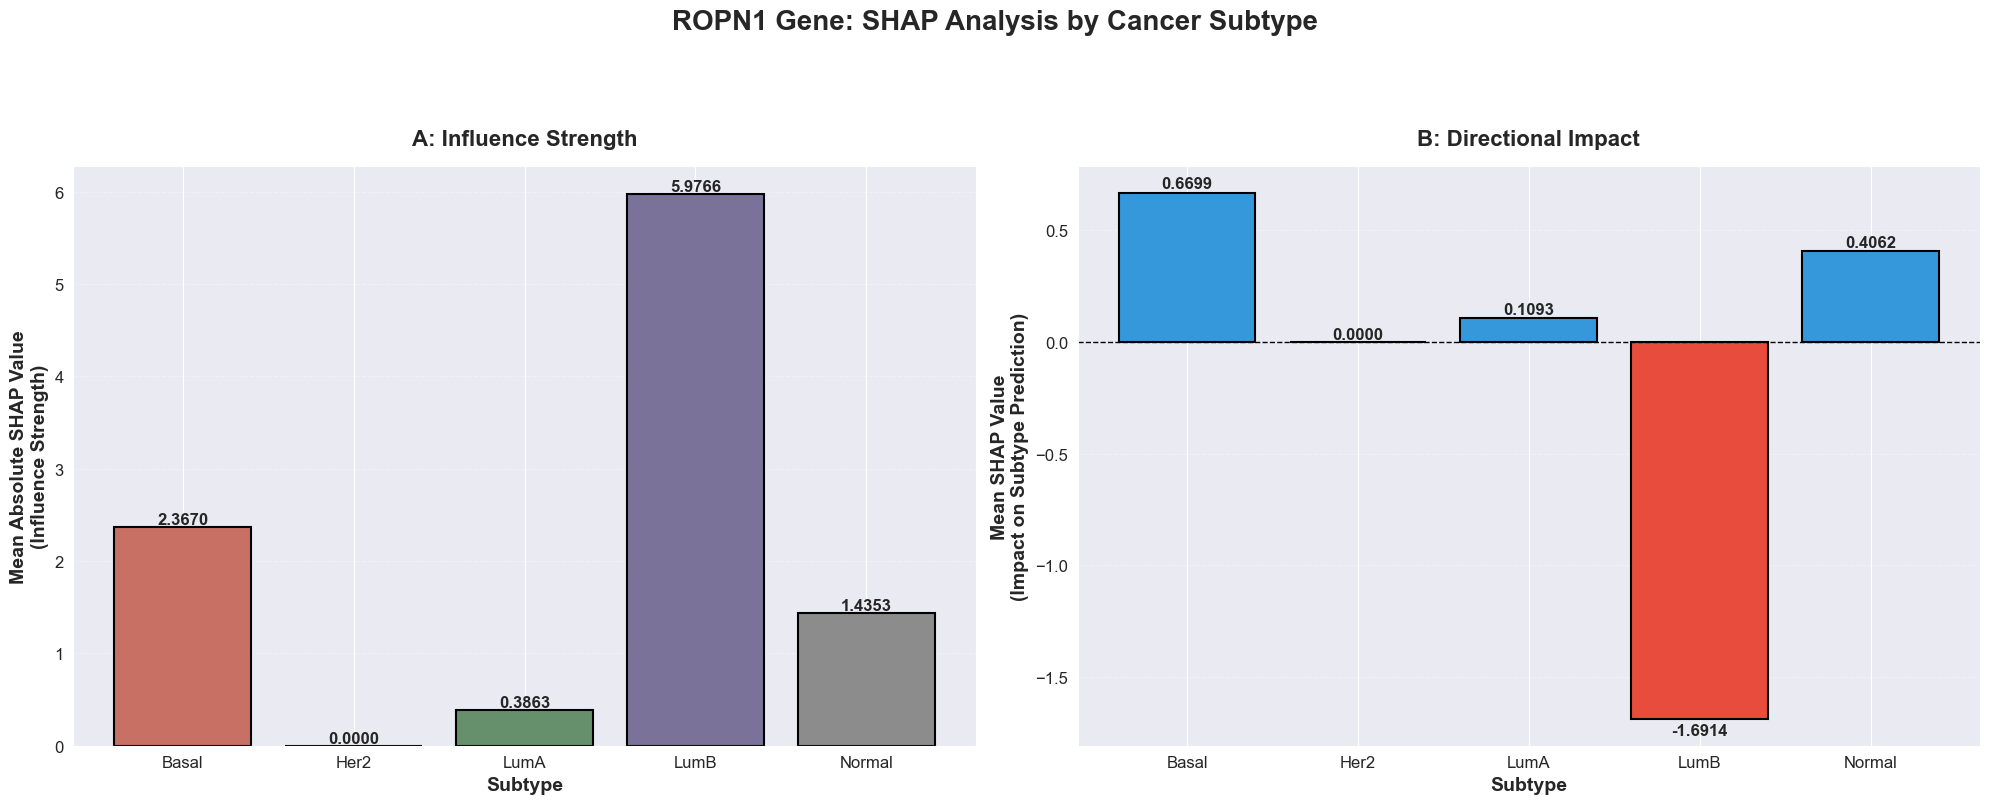

In [69]:
plot_shap_comparison("ROPN1")

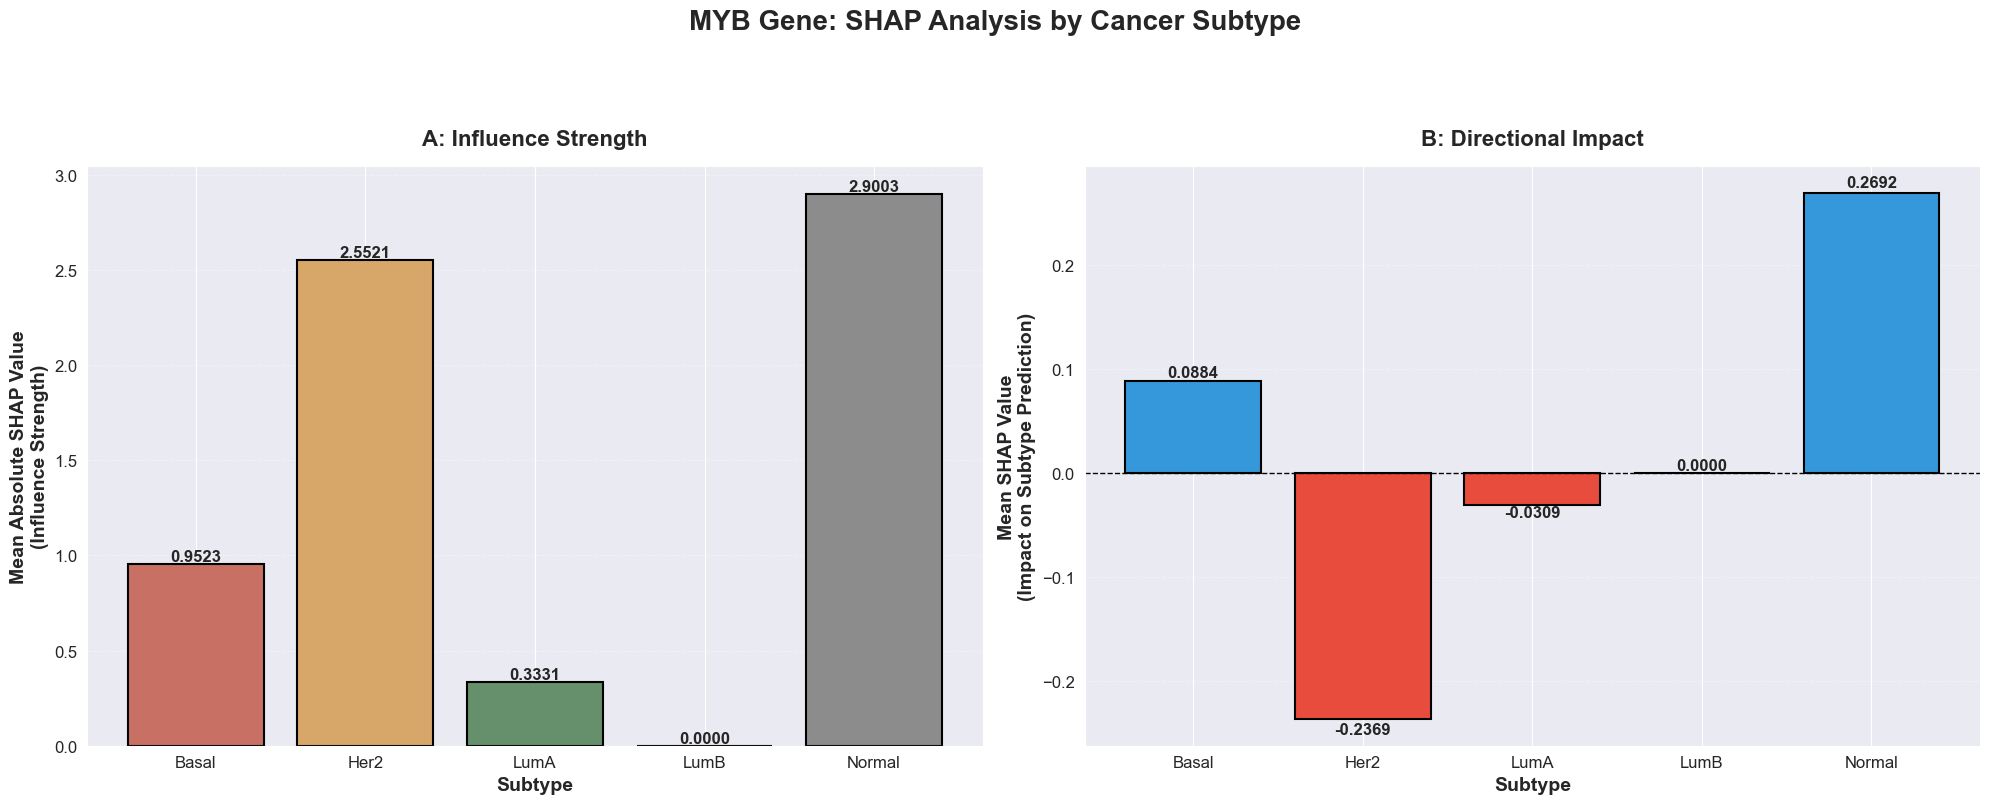

In [90]:
plot_shap_comparison("MYB")

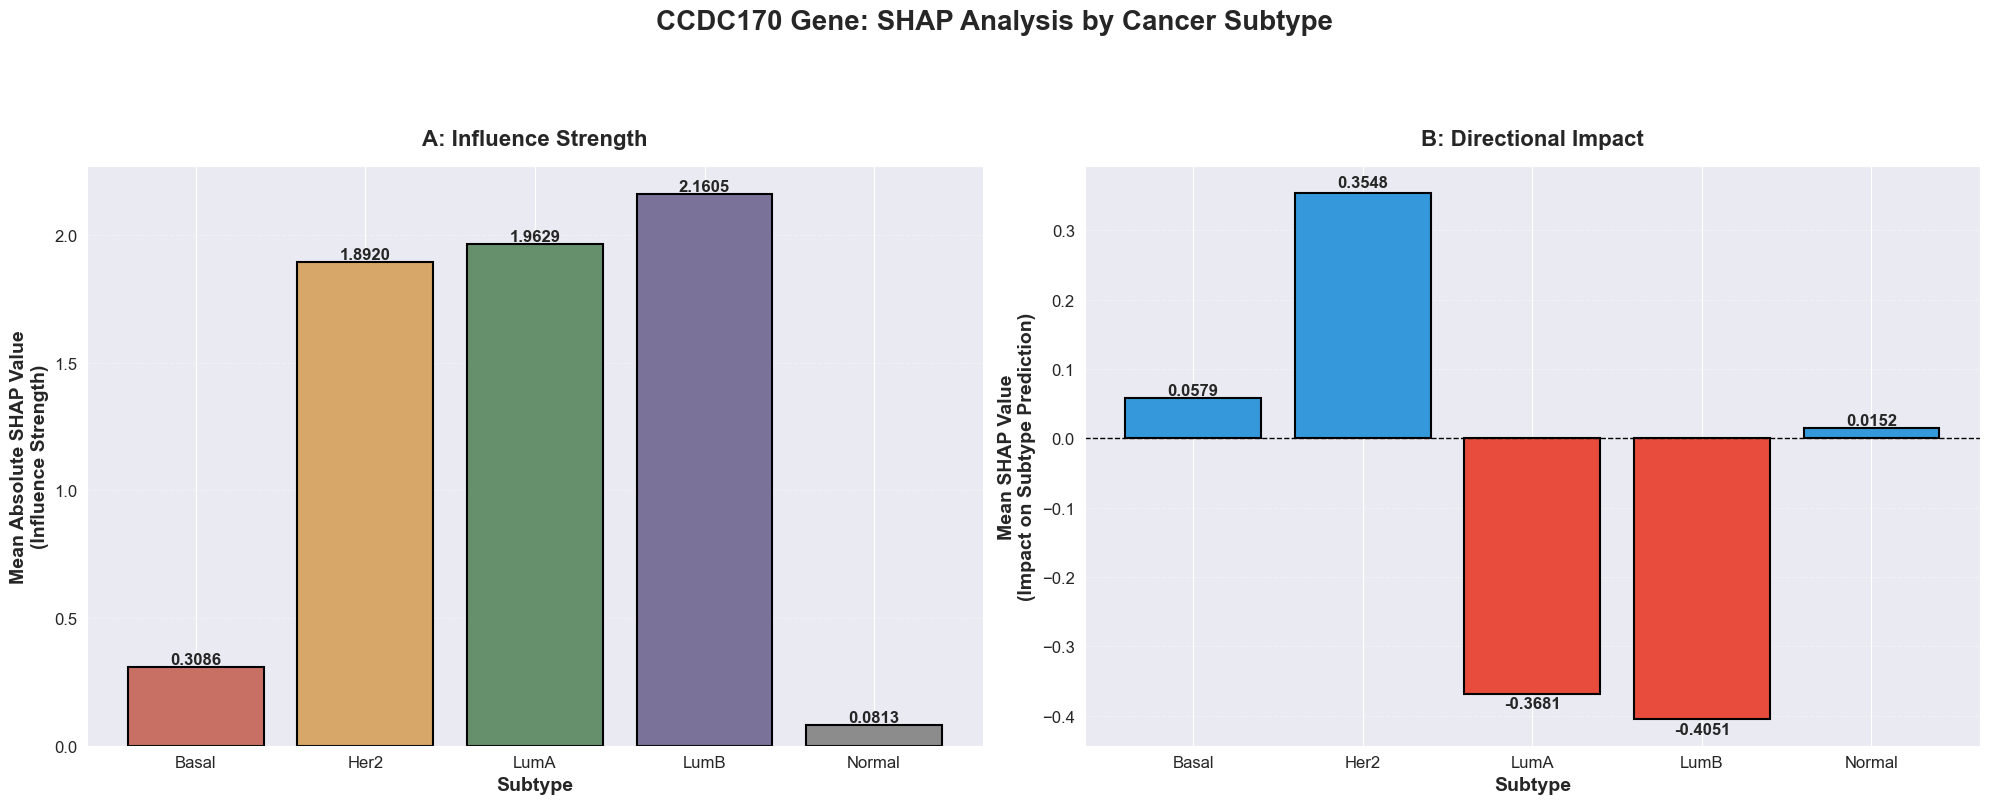

In [91]:
plot_shap_comparison("CCDC170")

In [92]:
def plot_shap_violin_by_subtype(gene_name: str):
    gene_idx = final_feature_names.index(gene_name)
    class_names = encoder.classes_
    shap_data_for_plot = []

    for class_idx, class_name_ in enumerate(class_names):
        shap_vals = shap_values.values[:, gene_idx, class_idx]
        for val in shap_vals:
            shap_data_for_plot.append({'Subtype': class_name_, 'SHAP Value': val})

    df_shap = pd.DataFrame(shap_data_for_plot)

    plt.figure(figsize=(12, 7))

    sns.violinplot(x='Subtype', y='SHAP Value', data=df_shap,
                   inner='quartile', palette='viridis', cut=0, linewidth=1.5, hue='Subtype')

    plt.axhline(0, color='black', linestyle='--', linewidth=1.5)

    plt.ylabel('SHAP Value (Impact on Prediction)', fontsize=14, fontweight='bold')
    plt.xlabel('Cancer Subtype', fontsize=14, fontweight='bold')
    plt.title(f'{gene_name} Gene: Distribution of SHAP Values by Subtype', fontsize=16, fontweight='bold', pad=20)

    plt.grid(axis='y', alpha=0.3, linestyle='--')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()


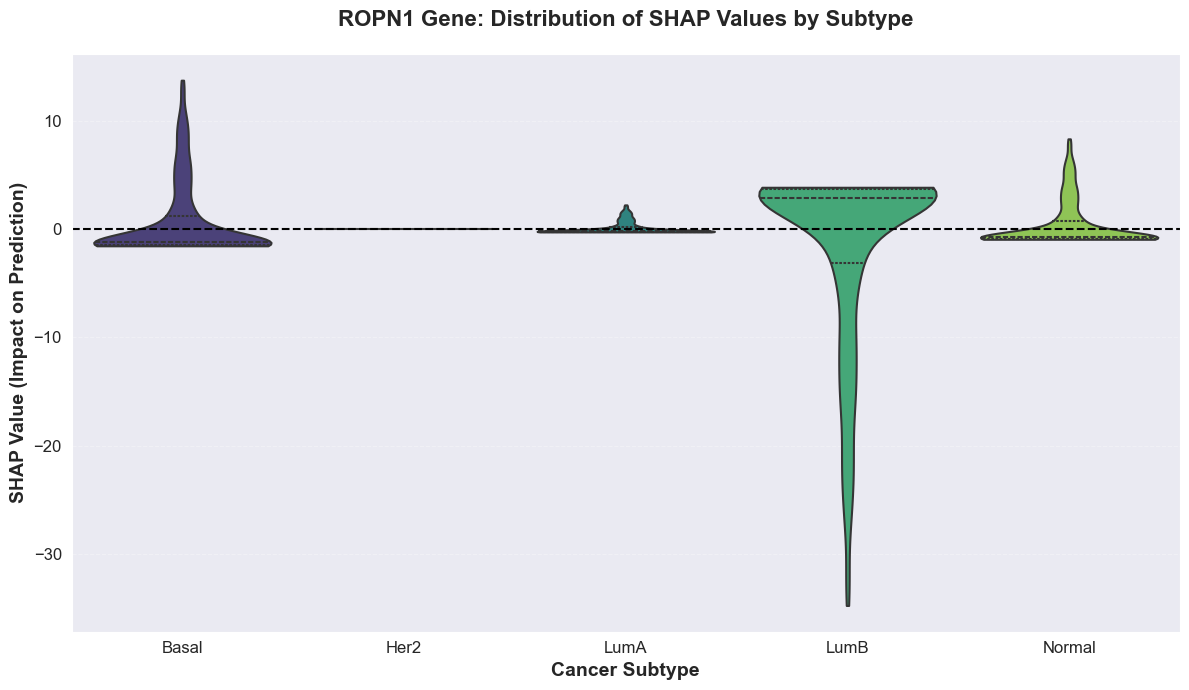

In [89]:
plot_shap_violin_by_subtype("ROPN1")

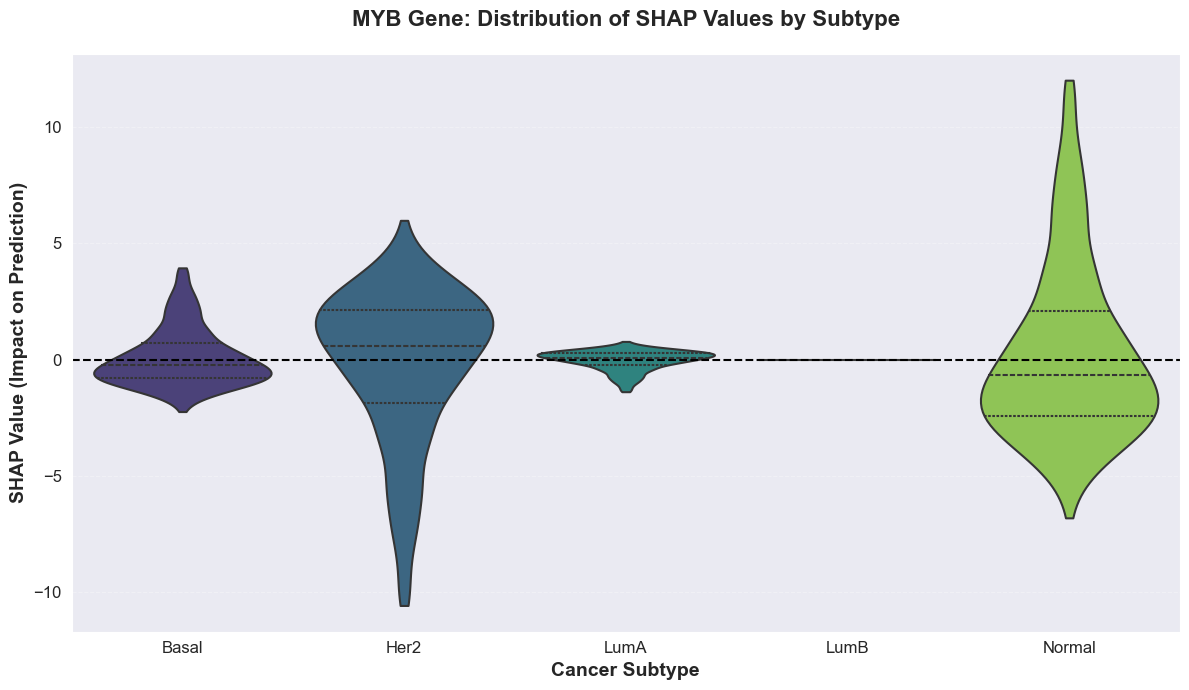

In [94]:
plot_shap_violin_by_subtype("MYB")

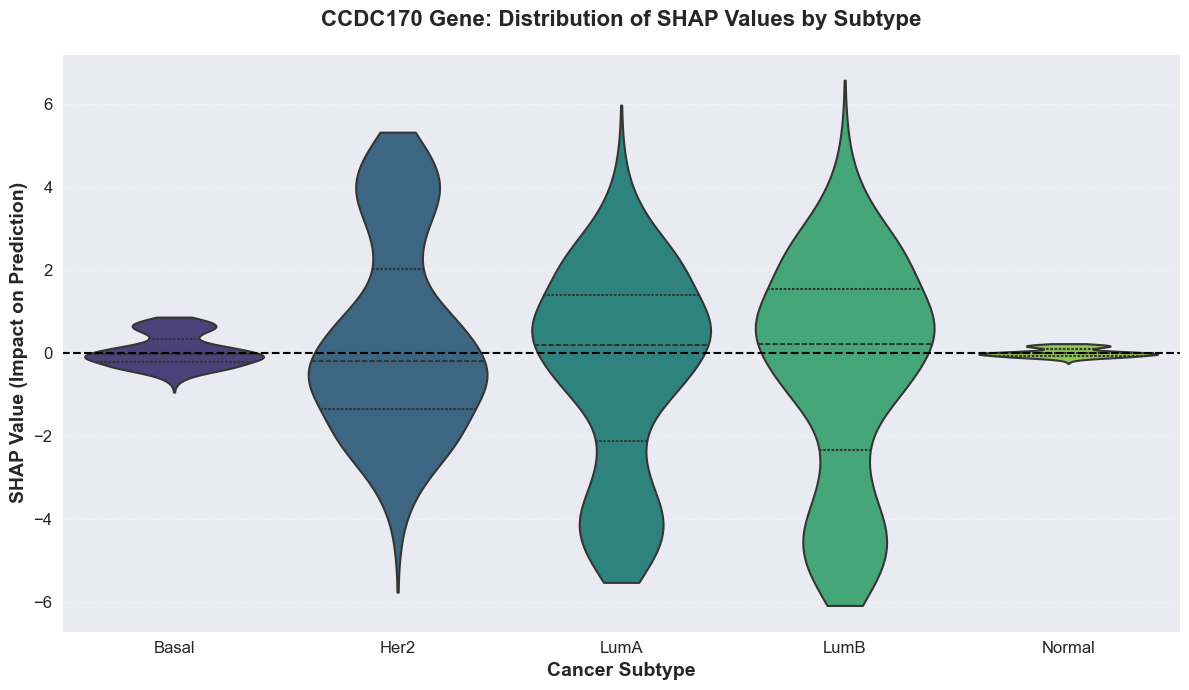

In [93]:
plot_shap_violin_by_subtype("CCDC170")

In [95]:

# --- This is the key part ---
# 1. Select the original (log2) data for ONLY the final features
#    `final_selected_gene_ids` is from your cell on page 21 [cite: 719]
#    `X_train` is your original log2-transformed data [cite: 180, 182]
try:
    X_train_subset = X_train[final_selected_gene_ids].copy()

    # 2. Rename the columns from ENSEMBL IDs to Gene Symbols
    #    `final_feature_names` is also from your cell on page 21 [cite: 729]
    X_train_subset.columns = final_feature_names

    print("Successfully created subset DataFrame for plotting.")
    print(f"Shape: {X_train_subset.shape}")

except NameError as e:
    print(f"Error: A required variable is not in memory. {e}")
    print("Please ensure 'X_train', 'final_selected_gene_ids', and 'final_feature_names' are defined.")

# --------------------------------

def plot_shap_dependence(gene_name: str, class_name: str):
    """
    Plots the SHAP dependence for a specific gene and a specific class.

    Assumes `shap_values`, `encoder`, and the `X_train_subset`
    DataFrame (created above) are available.
    """

    # 1. Get the index for the class (e.g., 'LumB')
    class_list = list(encoder.classes_)
    if class_name not in class_list:
        print(f"Error: Class '{class_name}' not found.")
        return
    class_idx = class_list.index(class_name)

    # 2. Get the SHAP values for *only* that class
    #    This is a 2D array: (n_samples, n_features)
    class_shap_values = shap_values.values[:, :, class_idx]

    print(f"\nGenerating dependence plot for gene '{gene_name}' in class '{class_name}'...")

    # 3. Create the plot
    #    'ind=gene_name' looks for the column 'gene_name' in X_train_subset
    #    'features=X_train_subset' provides the original (log2) values
    #    'shap_values=class_shap_values' provides the impact scores
    #    'interaction_index="auto"' automatically finds the most
    #    interesting second gene to color the dots by.
    shap.dependence_plot(
        ind=gene_name,
        shap_values=class_shap_values,
        features=X_train_subset,       # This is our new, unscaled subset
        interaction_index="auto",
        show=False
    )

    plt.title(f"SHAP Dependence: {gene_name} (for {class_name} Subtype)", fontsize=15)
    plt.ylabel(f"SHAP Value for {gene_name}", fontsize=12)
    plt.xlabel(f"Log2 Gene Expression", fontsize=12) # X-axis is now original data!
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

# --- Example Usage ---
# This will show WHY LumB has the long negative tail
# plot_shap_dependence('ROPN1', 'LumB')

# This will show WHY Basal has the long positive tail
# plot_shap_dependence('ROPN1', 'Basal')

Successfully created subset DataFrame for plotting.
Shape: (916, 50)



Generating dependence plot for gene 'CCDC170' in class 'LumB'...


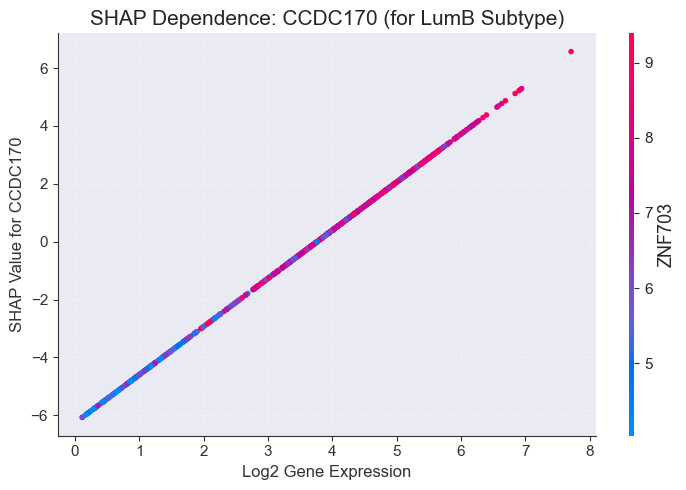

In [102]:
plot_shap_dependence("CCDC170", "LumB")